In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix

import mlflow
import mlflow.sklearn

%matplotlib inline

In [2]:
# data:
data_path = 'data/creditcard.csv'

In [3]:
df = pd.read_csv(data_path)
df = df.drop('Time', axis=1)

- We are removing 'Time' column because it was found to add data that isn't very helpful and only adds extra complexity to the data

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# normal and anomalies:

normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [6]:
print(f"Normal Shape: {normal.shape}")
print(f"Anomaly Shape: {anomaly.shape}")

Normal Shape: (142158, 30)
Anomaly Shape: (492, 30)


In [12]:
# Splitting the data:

normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

In [13]:
normal_train, normal_validate = train_test_split(normal_train, test_size=0.25, random_state=2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size=0.25, random_state=2020)

In [14]:
print(f"{normal_train.shape}, {normal_validate.shape}, {normal_test.shape}")
print(f"{anomaly_train.shape}, {anomaly_validate.shape}, {anomaly_test.shape}")

(85294, 30), (28432, 30), (28432, 30)
(393, 30), (99, 30), (99, 30)


In [16]:
# Now we can create the X y splits:

X_train = pd.concat((normal_train, anomaly_train))
X_test = pd.concat((normal_test, anomaly_test))
X_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(X_train['Class'])
y_test = np.array(X_test['Class'])
y_validate = np.array(X_validate['Class'])

X_train = X_train.drop('Class', axis=1)
X_test = X_test.drop('Class', axis=1)
X_validate = X_validate.drop('Class', axis=1)

In [17]:
print(f"Training:\n{X_train.shape}, {y_train.shape}")
print(f"Testing:\n{X_test.shape}, {y_test.shape}")
print(f"Validate:\n{X_validate.shape}, {y_validate.shape}")

Training:
(85588, 29), (85588,)
Testing:
(28531, 29), (28531,)
Validate:
(28531, 29), (28531,)


In [18]:
# Scaling the data:

scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop('Class', axis=1))

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validate = scaler.transform(X_validate)

## Training and Evaluating with MLFlow:

In [23]:
# function to train:
def train_model(model, X_train, y_train):
    model = model.fit(X_train, y_train)
    
    train_accuracy = model.score(X_train, y_train)
    mlflow.log_metric("train_accuracy", train_accuracy)
    
    print(f"Train Accuracy: {train_accuracy:.3%}")

In [24]:
# function to evaluate:
def evaluate_model(model, X_test, y_test):
    eval_accuracy = model.score(X_test, y_test)
    
    preds = model.predict(X_test)
    auc_score = roc_auc_score(y_test, preds)
    
    # logging the metrics:
    mlflow.log_metric("eval_accuracy", eval_accuracy)
    mlflow.log_metric("auc_score", auc_score)
    
    print(f"Eval Accuracy: {eval_accuracy:.3%}")
    print(f"AUC Score: {auc_score:.3%}")
    
    # plotting the ROC curve:
    roc_curve = plot_roc_curve(model, X_test, y_test, name='ROC Curve')
    plt.savefig("roc_plot.png")
    plt.show()
    plt.clf()
    
    # plotting the confusion matrix:
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    
    # logging these figures:
    mlflow.log_artifact("roc_plot.png")
    mlflow.log_artifact("confusion_matrix.png")

## Logging and Viewing MLFlow Runs:

Train Accuracy: 99.893%
Eval Accuracy: 99.874%
AUC Score: 85.341%


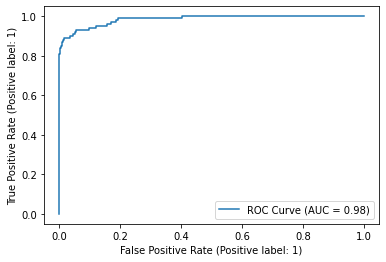

Model Run: 69e60427c9f143528915eed14945a2cd


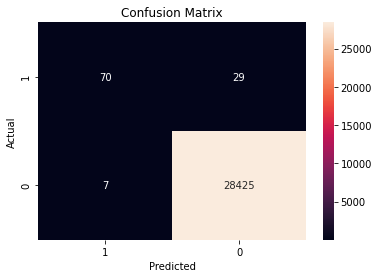

In [27]:
# creating the model:
model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')


# MLFlow experiment:
mlflow.set_experiment('logistic_regression_experiment')
with mlflow.start_run():
    # training:
    train_model(model, X_train, y_train)
    
    # evaluating:
    evaluate_model(model, X_test, y_test)
    
    # logging:
    mlflow.sklearn.log_model(model, 'logistic_regression_model')
    
    # printing model run info:
    print(f"Model Run: {mlflow.active_run().info.run_uuid}")
    
mlflow.end_run()

## Loading the Model:

In [29]:
# runs:/RUN_ID/MODEL_NAME
loaded_model = mlflow.sklearn.load_model('runs:/69e60427c9f143528915eed14945a2cd/logistic_regression_model')

In [31]:
print(loaded_model)
print(loaded_model.score(X_test, y_test))

LogisticRegression(max_iter=400, solver='newton-cg')
0.9987382145736217


## Model Validation with MLFlow:

In [33]:
# parameter tuning:

anomaly_weights = [ 1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [34]:
# broad search experiment:

mlflow.set_experiment('logreg_creditcard_broad_search')
logs = []

for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    
    for train, test in kfold.split(X_validate, y_validate):
        
        # starting the mlflow experiment:
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            
            # defining the class weights
            class_weights = {
                0: 1, 
                1: weight
            }
            
            # defining the model
            model = LogisticRegression(random_state=None,
                                      max_iter=400,
                                      solver='newton-cg',
                                      class_weight=class_weights).fit(X_validate[train], y_validate[train])
            
            # printing the metrics:
            for _ in range(40):
                print("-", end="")
            
            print(f"\nfold {fold}: \nAnomaly Weight: {weight}")
            
            train_accuracy = model.score(X_validate[train], y_validate[train])
            mlflow.log_metric("train_accuracy", train_accuracy)
            
            eval_accuracy = model.score(X_validate[test], y_validate[test])
            mlflow.log_metric("eval_accuracy", eval_accuracy)
            
            preds = model.predict(X_validate[test])
            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            
            mlflow.log_metric("auc_score", auc_score)
            
            print(f"AUC: {auc_score}\nEval Accuracy:{eval_accuracy}")
            
            accuracies.append(eval_accuracy)
            auc_scores.append(auc_score)
            
            log = [model, X_validate[test], y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(model, f"anomaly_weight_{weight}_fold_{fold}")
            
            fold = fold + 1
            
            # ending the mlflow run:
            mlflow.end_run()
            
    # printing the mean and max metrics:
    print("Averages:")
    print(f"Accuracy: {np.mean(accuracies)}")
    print(f"AUC: {np.mean(auc_scores)}")
    
    print("Best:")
    print(f"Accuracy: {np.max(accuracies)}")
    print(f"AUC: {np.max(auc_scores)}")

INFO: 'logreg_creditcard_broad_search' does not exist. Creating a new experiment
----------------------------------------
fold 1: 
Anomaly Weight: 1
AUC: 0.8
Eval Accuracy:0.9985982127212195
----------------------------------------
fold 2: 
Anomaly Weight: 1
AUC: 0.8568790049001132
Eval Accuracy:0.998422712933754
----------------------------------------
fold 3: 
Anomaly Weight: 1
AUC: 0.8406451922461774
Eval Accuracy:0.9982474588152822
----------------------------------------
fold 4: 
Anomaly Weight: 1
AUC: 0.8682452129973255
Eval Accuracy:0.9987732211706976
----------------------------------------
fold 5: 
Anomaly Weight: 1
AUC: 0.8528532875621686
Eval Accuracy:0.9989484752891693
Averages:
Accuracy: 0.9985980161860246
AUC: 0.8437245395411569
Best:
Accuracy: 0.9989484752891693
AUC: 0.8682452129973255
----------------------------------------
fold 1: 
Anomaly Weight: 5
AUC: 0.8748241603657465
Eval Accuracy:0.9987734361310671
----------------------------------------
fold 2: 
Anomaly Weigh

##### The best results that we got were from anomaly weights 10 and 15.

In [36]:
# guided search:

anomaly_weights = [10, 50, 100, 150, 200]
num_folds = 5
kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [37]:
# setting up the new experiment:

mlflow.set_experiment('logreg_creditcard_guided_search')
logs = []

for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    
    for train, test in kfold.split(X_validate, y_validate):
        
        # starting the mlflow experiment:
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            
            # defining the class weights
            class_weights = {
                0: 1, 
                1: weight
            }
            
            # defining the model
            model = LogisticRegression(random_state=None,
                                      max_iter=400,
                                      solver='newton-cg',
                                      class_weight=class_weights).fit(X_validate[train], y_validate[train])
            
            # printing the metrics:
            for _ in range(40):
                print("-", end="")
            
            print(f"\nfold {fold}: \nAnomaly Weight: {weight}")
            
            train_accuracy = model.score(X_validate[train], y_validate[train])
            mlflow.log_metric("train_accuracy", train_accuracy)
            
            eval_accuracy = model.score(X_validate[test], y_validate[test])
            mlflow.log_metric("eval_accuracy", eval_accuracy)
            
            preds = model.predict(X_validate[test])
            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            
            mlflow.log_metric("auc_score", auc_score)
            
            print(f"AUC: {auc_score}\nEval Accuracy:{eval_accuracy}")
            
            accuracies.append(eval_accuracy)
            auc_scores.append(auc_score)
            
            log = [model, X_validate[test], y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(model, f"anomaly_weight_{weight}_fold_{fold}")
            
            fold = fold + 1
            
            # ending the mlflow run:
            mlflow.end_run()
            
    # printing the mean and max metrics:
    print("Averages:")
    print(f"Accuracy: {np.mean(accuracies)}")
    print(f"AUC: {np.mean(auc_scores)}")
    
    print("Best:")
    print(f"Accuracy: {np.max(accuracies)}")
    print(f"AUC: {np.max(auc_scores)}")

INFO: 'logreg_creditcard_guided_search' does not exist. Creating a new experiment
----------------------------------------
fold 1: 
Anomaly Weight: 10
AUC: 0.9243845612801126
Eval Accuracy:0.9982477659015244
----------------------------------------
fold 2: 
Anomaly Weight: 10
AUC: 0.9753109687146626
Eval Accuracy:0.9980722046968104
----------------------------------------
fold 3: 
Anomaly Weight: 10
AUC: 0.9313783507133262
Eval Accuracy:0.9985979670522257
----------------------------------------
fold 4: 
Anomaly Weight: 10
AUC: 0.8943851628367561
Eval Accuracy:0.9985979670522257
----------------------------------------
fold 5: 
Anomaly Weight: 10
AUC: 0.8820013855427915
Eval Accuracy:0.9985979670522257
Averages:
Accuracy: 0.9984227743510024
AUC: 0.9214920858175297
Best:
Accuracy: 0.9985979670522257
AUC: 0.9753109687146626
----------------------------------------
fold 1: 
Anomaly Weight: 50
AUC: 0.922626164937577
Eval Accuracy:0.9947432977045734
----------------------------------------


###### - From the above we see that AUC score increases as we increase the weights from 10 to 15 to 100 to 150 and 200
###### - The best AUC score we get is when the anomaly weight is 200.